In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tabulate import tabulate
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from sklearn.model_selection import cross_validate

In [2]:
!pip install -U seaborn

In [3]:
file_path = 'knn_imputation.xlsx'  
df = pd.read_excel(file_path)

now let us try binary classification methods to split our data into two groups:
first we can set an arbitrary binary classification threshold at the median of our redshift value

In [4]:
cutoff = df['Redshift'].median()
cutoff = cutoff+cutoff/100
cutoff=2
print('redshift cutoff:', cutoff)

redshift cutoff: 2


In [446]:
print('Number of GRBs with redshift > 2:', (df['Redshift'] > cutoff).sum())
print(419-195)

Number of GRBs with redshift > 2: 195
224


data preparation is below

helper function is below

In [12]:
def evaluate_model_with_crossval(model, X, y, cv=kfold):
    scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)

    validation_metrics = [
            ["Accuracy", f"{scores['test_accuracy'].mean():.2f} ± {scores['test_accuracy'].std():.2f}"],
            ["Precision", f"{scores['test_precision'].mean():.2f} ± {scores['test_precision'].std():.2f}"],
            ["Recall", f"{scores['test_recall'].mean():.2f} ± {scores['test_recall'].std():.2f}"],
            ["F1 Score", f"{scores['test_f1'].mean():.2f} ± {scores['test_f1'].std():.2f}"],
            ["ROC AUC", f"{scores['test_roc_auc'].mean():.2f} ± {scores['test_roc_auc'].std():.2f}"]
    ]


    
    training_metrics = [
        ["Accuracy", f"{scores['train_accuracy'].mean():.2f} ± {scores['train_accuracy'].std():.2f}"],
        ["Precision", f"{scores['train_precision'].mean():.2f} ± {scores['train_precision'].std():.2f}"],
        ["Recall", f"{scores['train_recall'].mean():.2f} ± {scores['train_recall'].std():.2f}"],
        ["F1 Score", f"{scores['train_f1'].mean():.2f} ± {scores['train_f1'].std():.2f}"],
        ["ROC AUC", f"{scores['train_roc_auc'].mean():.2f} ± {scores['train_roc_auc'].std():.2f}"]
    ]
    
    print("Cross Validation Metrics for 20 k-folds:")
    print(tabulate(validation_metrics, headers=["Metric", "Value"]))
    print("\n")
    print("Metrics on the cross validation's training data:")
    print(tabulate(training_metrics, headers=["Metric", "Value"]))


def plot_confusion_matrix_and_stats(y_true, y_pred, model_name, cutoff, data_type):

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])

    plt.figure(figsize=(8, 6))
    labels = ['Low Redshift', 'High Redshift'] #low redshift is 0, high redshift is 1
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                linewidths=0.5, linecolor='white', cbar=True)    
    plt.xlabel('Predicted Redshift')
    plt.ylabel('True Redshift')
    plt.title(f'Confusion Matrix for model {model_name} (cutoff {cutoff:.3g}) on the {data_type}')
    plt.tight_layout()
    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    metrics_table = [
        ["Accuracy", f"{accuracy:.2f}"],
        ["Precision", f"{precision:.2f}"],
        ["Recall", f"{recall:.2f}"],
        ["F1 Score", f"{f1:.2f}"]
    ]
    print(f"Classification Metrics for Single Run on the {data_type}")
    print(tabulate(metrics_table, headers=["Metric", "Value"]))


In [ ]:
y_initial = (df['Redshift'] > cutoff).astype(int) ##value of 1 is assigned if the redshift is greater than the cutoff, otherwise 0
X_initial = df.drop(columns=['GRB', 'Redshift'])

X_train, X_test, y_train, y_test = train_test_split(X_initial, y_initial, test_size=0.2)
#do not touch X_test and y_test until the very end.

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns) #this is defensive coding
#in case the indices change, since scaling the data will lose the indexing that we had.
y = y_train

#below is k fold cross validation but only performed once
kfold = KFold(n_splits=5, shuffle=True) #we wipe this variable out in the next line
#below is kfold validation but performed about 20 times
kfold = RepeatedKFold(n_splits=5, n_repeats=4)

start running analyses, first off let's use a naive bayes classifier

Cross Validation Metrics for 20 k-folds:
Metric     Value
---------  -----------
Accuracy   0.66 ± 0.05
Precision  0.59 ± 0.05
Recall     0.85 ± 0.07
F1 Score   0.69 ± 0.05
ROC AUC    0.74 ± 0.05


Metrics on the cross validation's training data:
Metric     Value
---------  -----------
Accuracy   0.68 ± 0.02
Precision  0.60 ± 0.02
Recall     0.90 ± 0.02
F1 Score   0.72 ± 0.01
ROC AUC    0.79 ± 0.01


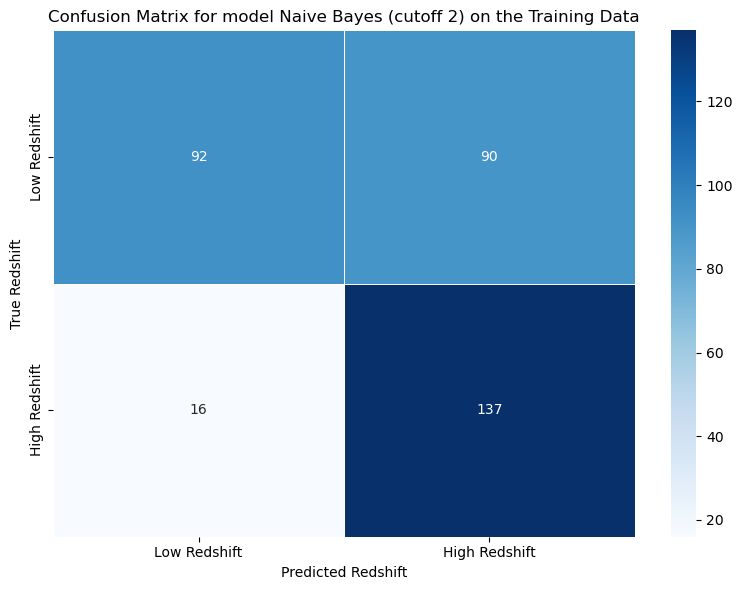

Classification Metrics for Single Run on the Training Data
Metric       Value
---------  -------
Accuracy      0.68
Precision     0.6
Recall        0.9
F1 Score      0.72


In [ ]:
model_name = 'Naive Bayes'
model = GaussianNB()
evaluate_model_with_crossval(model, X_scaled, y) #here we are evauating our model with cross validation
#this is helps predict how the model would perform on unseen data
model.fit(X_scaled, y) #here we fit our model to the training data
y_pred = model.predict(X_scaled) #here we predict on the training data, this helps gauge our level of overfitting
plot_confusion_matrix_and_stats(y, y_pred, model_name, cutoff, 'Training Data') #this gets us our statistics and confusion matrix JUST for the training data

In [41]:
#here we implement a little bit of hyperparameter tuning on the gaussian naive bayes model
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]} #after playing with this parameter, it just seems to prefer a paramter value of 0
#i.e., if i keep lowering the parameter it will keep selecting the lowest value.
model = GaussianNB()
grid = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy')
grid.fit(X_scaled, y)
var_smoothing = grid.best_params_['var_smoothing']
print("Best parameters for Gaussian Naive Bayes:", var_smoothing)
print("Best cross-validation score for Gaussian Naive Bayes (accurracy):", grid.best_score_)

Best parameters for Gaussian Naive Bayes: 1e-09
Best cross-validation score for Gaussian Naive Bayes (accurracy): 0.6634328358208954


In [42]:
best_model = grid.best_estimator_ #this gives us directly the best model from our grid search
evaluate_model_with_crossval(best_model, X_scaled, y) #here we are evauating our model with cross validation

Cross Validation Metrics for 20 k-folds:
Metric     Value
---------  -----------
Accuracy   0.66 ± 0.07
Precision  0.59 ± 0.06
Recall     0.86 ± 0.06
F1 Score   0.70 ± 0.06
ROC AUC    0.73 ± 0.06


Metrics on the cross validation's training data:
Metric     Value
---------  -----------
Accuracy   0.68 ± 0.02
Precision  0.60 ± 0.02
Recall     0.90 ± 0.01
F1 Score   0.72 ± 0.02
ROC AUC    0.79 ± 0.01


Cross Validation Metrics for 20 k-folds:
Metric     Value
---------  -----------
Accuracy   0.69 ± 0.05
Precision  0.66 ± 0.08
Recall     0.67 ± 0.09
F1 Score   0.66 ± 0.06


Metrics on the cross validation's training data:
Metric     Value
---------  -----------
Accuracy   0.78 ± 0.01
Precision  0.75 ± 0.02
Recall     0.78 ± 0.03
F1 Score   0.77 ± 0.02


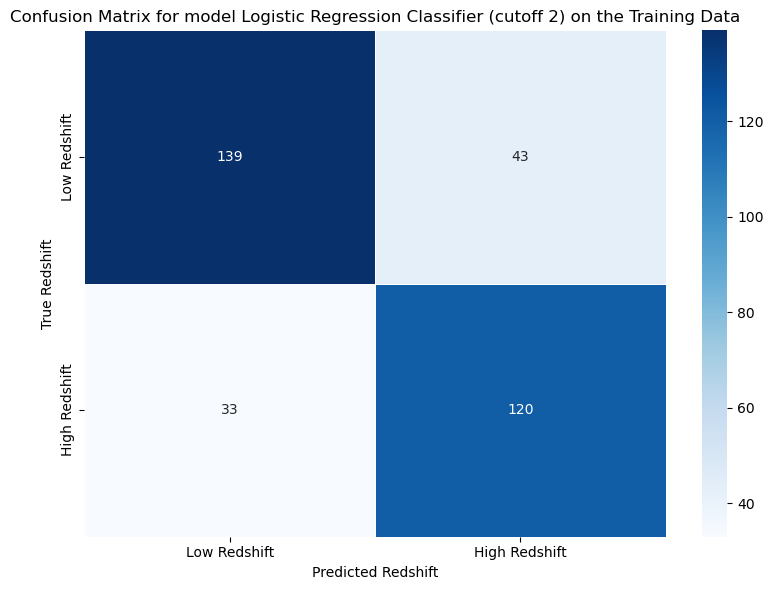

Classification Metrics for Single Run on the Training Data
Metric       Value
---------  -------
Accuracy      0.77
Precision     0.74
Recall        0.78
F1 Score      0.76


In [22]:
model_name = 'Logistic Regression Classifier'
model = LogisticRegression(max_iter=1000)

evaluate_model_with_crossval(model, X_scaled, y) #here we are evauating our model with cross validation
#this helps predict how the model would perform on unseen data
model.fit(X_scaled, y) #here we fit our model to the training data
y_pred = model.predict(X_scaled) #here we predict on the training data, this helps gauge our level of overfitting
plot_confusion_matrix_and_stats(y, y_pred, model_name, cutoff, 'Training Data') #this gets us our statistics and confusion matrix JUST for the training data

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 0.5, 0.6, 1,1.1, 1.2],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}
grid = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
grid.fit(X_scaled, y)
best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Best parameters: {'C': 1.1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV Accuracy: 0.6865671641791046


In [ ]:
best_model = LogisticRegression('C'=1.1,)
evaluate_model_with_crossval(best_model, X_scaled, y) #here we are evauating our model with cross validation

Cross Validation Metrics for 20 k-folds:
Metric     Value
---------  -----------
Accuracy   0.68 ± 0.05
Precision  0.65 ± 0.09
Recall     0.67 ± 0.12
F1 Score   0.65 ± 0.07
ROC AUC    0.75 ± 0.05


Metrics on the cross validation's training data:
Metric     Value
---------  -----------
Accuracy   0.78 ± 0.01
Precision  0.75 ± 0.02
Recall     0.78 ± 0.02
F1 Score   0.77 ± 0.01
ROC AUC    0.87 ± 0.01


Cross Validation Metrics for 20 k-folds:
Metric     Value
---------  -----------
Accuracy   0.65 ± 0.06
Precision  0.61 ± 0.07
Recall     0.63 ± 0.11
F1 Score   0.62 ± 0.07
ROC AUC    0.70 ± 0.06


Metrics on the cross validation's training data:
Metric     Value
---------  -----------
Accuracy   0.73 ± 0.02
Precision  0.70 ± 0.04
Recall     0.72 ± 0.07
F1 Score   0.71 ± 0.03
ROC AUC    0.80 ± 0.02


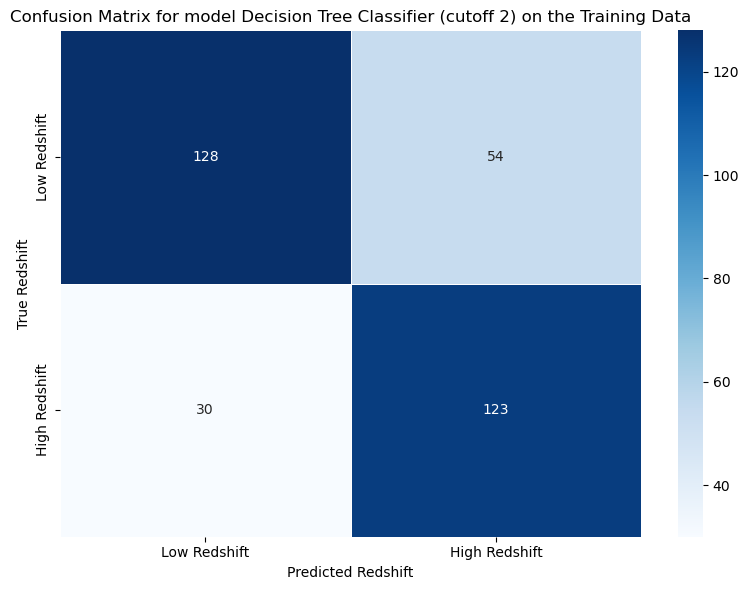

Classification Metrics for Single Run on the Training Data
Metric       Value
---------  -------
Accuracy      0.75
Precision     0.69
Recall        0.8
F1 Score      0.75


In [ ]:
from sklearn.tree import DecisionTreeClassifier

model_name = 'Decision Tree Classifier'
model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4,
    min_samples_split=8,
    min_samples_leaf=20,
    max_features='sqrt',
)
evaluate_model_with_crossval(model, X_scaled, y)
model.fit(X_scaled, y)
y_pred = model.predict(X_scaled)
plot_confusion_matrix_and_stats(y, y_pred, model_name, cutoff, 'Training Data')

In [ ]:
model = DecisionTreeClassifier()

param_grid = {
    'max_depth': [None, 3, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}
grid = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
grid.fit(X_scaled, y)
best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 5}
Best CV Accuracy: 0.6626865671641792


In [51]:
evaluate_model_with_crossval(best_model, X_scaled, y)

Cross Validation Metrics for 20 k-folds:
Metric     Value
---------  -----------
Accuracy   0.66 ± 0.05
Precision  0.61 ± 0.08
Recall     0.71 ± 0.16
F1 Score   0.65 ± 0.09
ROC AUC    0.69 ± 0.05


Metrics on the cross validation's training data:
Metric     Value
---------  -----------
Accuracy   0.81 ± 0.03
Precision  0.76 ± 0.06
Recall     0.87 ± 0.09
F1 Score   0.81 ± 0.03
ROC AUC    0.89 ± 0.03


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [5, 6, 8],
    'min_samples_leaf': [5, 7, 9],
    'criterion': ['gini', 'entropy']
}
grid = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
grid.fit(X_scaled, y)
best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)


Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 9, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Accuracy: 0.7149253731343282


In [ ]:
model_name = 'Tuned Random Forest Classifier'

best_model = RandomForestClassifier(criterion='entropy', max_depth=2, min_samples_leaf=25, min_samples_split=25, n_estimators=100)
evaluate_model_with_crossval(best_model, X_scaled, y)
best_model.fit(X_scaled, y)
y_pred = best_model.predict(X_scaled)
plot_confusion_matrix_and_stats(y, y_pred, model_name, cutoff, 'Training Data')

Cross Validation Metrics for 20 k-folds:
Metric     Value
---------  -----------
Accuracy   0.69 ± 0.05
Precision  0.63 ± 0.08
Recall     0.80 ± 0.08
F1 Score   0.70 ± 0.06
ROC AUC    0.77 ± 0.06


Metrics on the cross validation's training data:
Metric     Value
---------  -----------
Accuracy   0.73 ± 0.02
Precision  0.66 ± 0.02
Recall     0.84 ± 0.03
F1 Score   0.74 ± 0.01
ROC AUC    0.85 ± 0.01


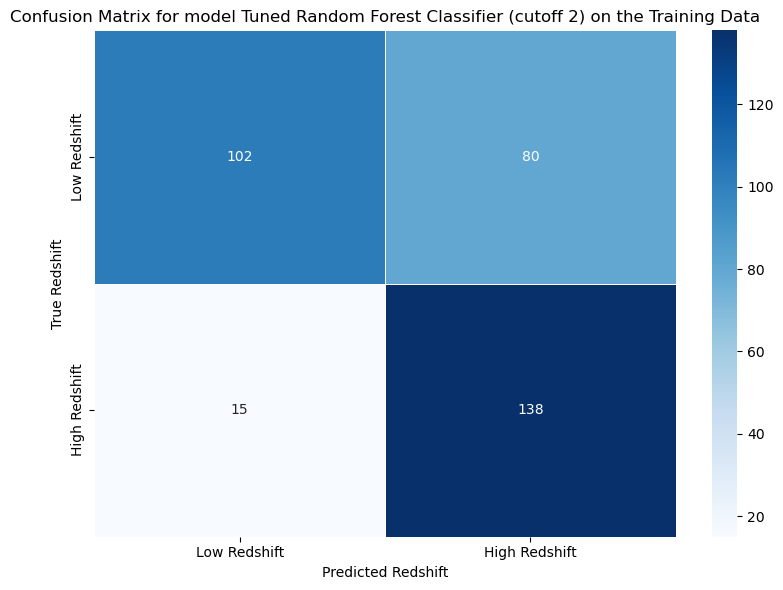

Classification Metrics for Single Run on the Training Data
Metric       Value
---------  -------
Accuracy      0.72
Precision     0.63
Recall        0.9
F1 Score      0.74


In [ ]:
model_name = 'Tuned Random Forest Classifier'

best_model = RandomForestClassifier(criterion='entropy', max_depth=2, min_samples_leaf=25, min_samples_split=25, n_estimators=100)
evaluate_model_with_crossval(best_model, X_scaled, y)
best_model.fit(X_scaled, y)
y_pred = best_model.predict(X_scaled)
plot_confusion_matrix_and_stats(y, y_pred, model_name, cutoff, 'Training Data')

below we have gradient boosting classifier

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
model = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [2, 4],
    'subsample': [0.6, 0.8, 1.0]
}
grid = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy', n_jobs=-1)
grid.fit(X_scaled, y)
best_model = grid.best_estimator_
print("Best parameters:", grid.best_params_)
print("Best CV Accuracy:", grid.best_score_)

Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'subsample': 0.8}
Best CV Accuracy: 0.7067164179104478


Cross Validation Metrics for 20 k-folds:
Metric     Value
---------  -----------
Accuracy   0.70 ± 0.05
Precision  0.67 ± 0.08
Recall     0.70 ± 0.10
F1 Score   0.67 ± 0.05
ROC AUC    0.78 ± 0.04


Metrics on the cross validation's training data:
Metric     Value
---------  -----------
Accuracy   0.79 ± 0.01
Precision  0.77 ± 0.02
Recall     0.78 ± 0.04
F1 Score   0.77 ± 0.02
ROC AUC    0.87 ± 0.01


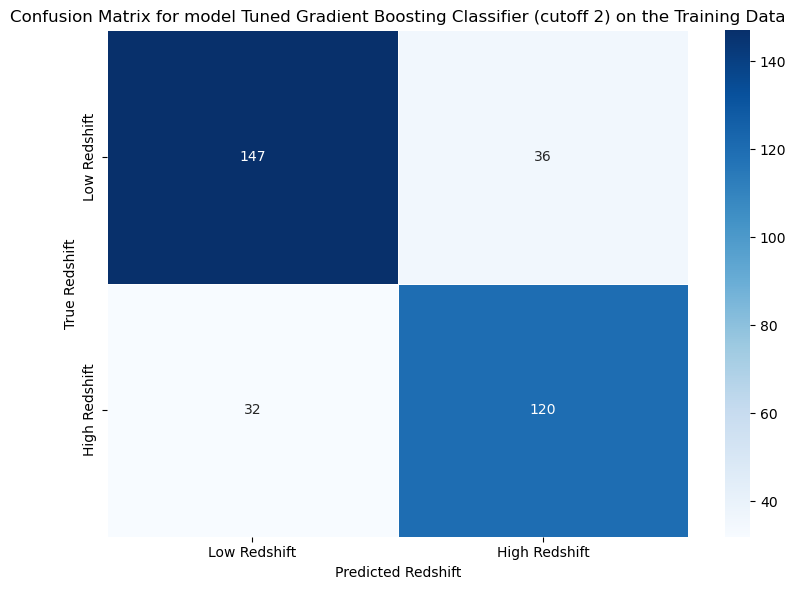

Classification Metrics for Single Run on the Training Data
Metric       Value
---------  -------
Accuracy      0.8
Precision     0.77
Recall        0.79
F1 Score      0.78


In [ ]:
model_name = 'Tuned Gradient Boosting Classifier'

best_model = GradientBoostingClassifier(learning_rate=0.003, max_depth=2, min_samples_leaf=20, min_samples_split=20, n_estimators=500, subsample=0.55, max_features='log2')
evaluate_model_with_crossval(best_model, X_scaled, y)
best_model.fit(X_scaled, y)
y_pred = best_model.predict(X_scaled)
plot_confusion_matrix_and_stats(y, y_pred, model_name, cutoff, 'Training Data')

/var/folders/m4/klwbvmz53qz_9m21j1nzhhkh0000gn/T/ipykernel_37846/2222099216.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='inferno')


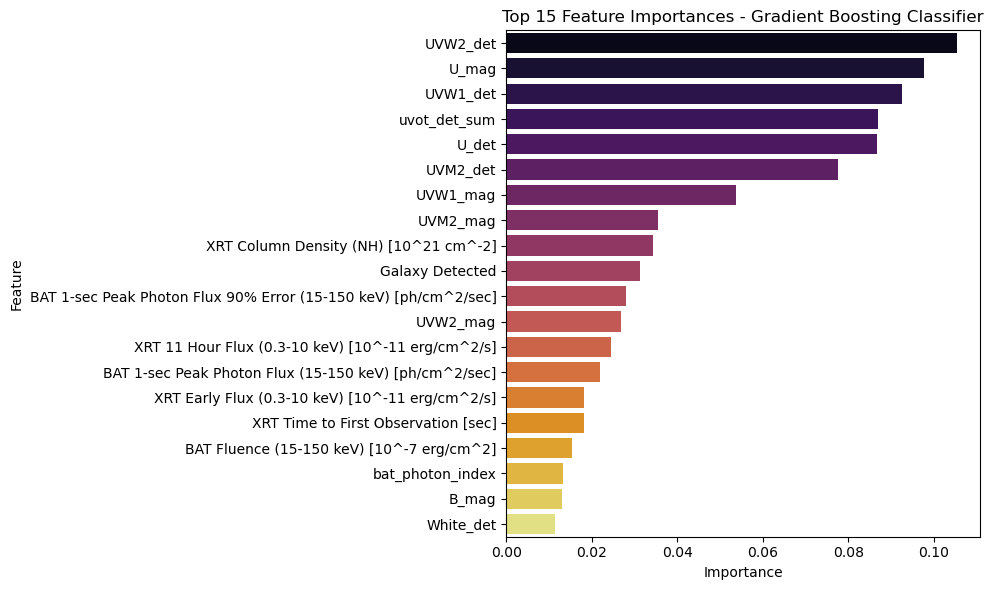

In [ ]:
#get feature importance
importances = best_model.feature_importances_
feature_names = X_scaled.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='inferno')
plt.title('Top 15 Feature Importances - Gradient Boosting Classifier')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

below we have xgboost classifier

now let's build a neural network, partially because it's more fun.

In [8]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, BatchNormalization, Input, Add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report

this is a helper function for neural network training

In [229]:
print(X_scaled.shape)
print(y.shape)

(335, 41)
(335,)


In [6]:
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.25)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)    
print(y_val.shape)

(251, 41)
(84, 41)
(251,)
(84,)


In [28]:
regularization = 0.015
learning_rate = 0.01
activation_function = 'relu'

model = Sequential([
    Dense(256, activation=activation_function, kernel_regularizer=l2(regularization), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation=activation_function, kernel_regularizer=l2(regularization), input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation=activation_function, kernel_regularizer=l2(regularization)),
    BatchNormalization(),
    Dropout(0.3),

    Dense(64, activation=activation_function, kernel_regularizer=l2(regularization)),
    BatchNormalization(),
    Dropout(0.2),

    Dense(32, activation=activation_function, kernel_regularizer=l2(regularization)),
    Dropout(0.2),

    Dense(1, activation='sigmoid') 
])


model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss='binary_crossentropy',
    metrics=['accuracy'],
)

early_stop = EarlyStopping(patience=20, restore_best_weights=True)


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=300,
    batch_size=32,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/300
8/8 [==============================] - 1s 18ms/step - loss: 9.6691 - accuracy: 0.5219 - val_loss: 9.0349 - val_accuracy: 0.5833
Epoch 2/300
8/8 [==============================] - 0s 4ms/step - loss: 8.3227 - accuracy: 0.6414 - val_loss: 7.4650 - val_accuracy: 0.5833
Epoch 3/300
8/8 [==============================] - 0s 4ms/step - loss: 6.4997 - accuracy: 0.6813 - val_loss: 5.4747 - val_accuracy: 0.5833
Epoch 4/300
8/8 [==============================] - 0s 4ms/step - loss: 4.6206 - accuracy: 0.7689 - val_loss: 3.8320 - val_accuracy: 0.6667
Epoch 5/300
8/8 [==============================] - 0s 4ms/step - loss: 3.2643 - accuracy: 0.7052 - val_loss: 2.7765 - val_accuracy: 0.6667
Epoch 6/300
8/8 [==============================] - 0s 4ms/step - loss: 2.3228 - accuracy: 0.7729 - val_loss: 2.1763 - val_accuracy: 0.7619
Epoch 7/300
8/8 [==============================] - 0s 5ms/step - loss: 1.9626 - accuracy: 0.7729 - val_loss: 1.8902 - val_accuracy: 0.6667
Epoch 8/300
8/8 [=========

3/3 [==============================] - 0s 974us/step
              precision    recall  f1-score   support

           0       0.94      0.59      0.72        49
           1       0.62      0.94      0.75        35

    accuracy                           0.74        84
   macro avg       0.78      0.77      0.74        84
weighted avg       0.81      0.74      0.74        84



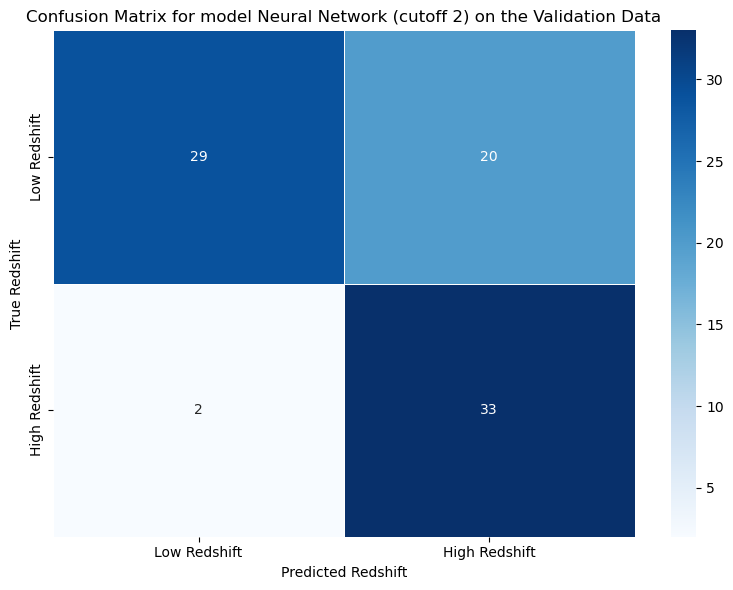

Classification Metrics for Single Run on the Validation Data
Metric       Value
---------  -------
Accuracy      0.74
Precision     0.62
Recall        0.94
F1 Score      0.75


In [29]:
y_pred = model.predict(X_val).flatten()
y_pred = (model.predict(X_val) >= 0.5).astype(int)
print(classification_report(y_val, y_pred))
plot_confusion_matrix_and_stats(y_val, y_pred, 'Neural Network', 2, 'Validation Data')

In [15]:
print(y_test_pred)

[[0.58990574]
 [0.48122647]
 [0.6306133 ]
 [0.6636745 ]
 [0.70787895]
 [0.6630389 ]
 [0.12987195]
 [0.6482194 ]
 [0.7082716 ]
 [0.63755196]
 [0.7139905 ]
 [0.66475886]
 [0.68246853]
 [0.44960493]
 [0.7548929 ]
 [0.724919  ]
 [0.6791951 ]
 [0.6508728 ]
 [0.42439634]
 [0.3995718 ]
 [0.51052755]
 [0.45291784]
 [0.61189836]
 [0.60266834]
 [0.34846693]
 [0.5140343 ]
 [0.64735097]
 [0.666629  ]
 [0.6831618 ]
 [0.704175  ]
 [0.5750306 ]
 [0.6524424 ]
 [0.54303986]
 [0.5205771 ]
 [0.6641962 ]
 [0.47223502]
 [0.6311923 ]
 [0.59284705]
 [0.42895284]
 [0.40530413]
 [0.65311915]
 [0.6029359 ]
 [0.67240894]
 [0.48925215]
 [0.46691412]
 [0.5047816 ]
 [0.5460983 ]
 [0.6223893 ]
 [0.5448092 ]
 [0.4904929 ]
 [0.4093981 ]
 [0.50256085]
 [0.6687921 ]
 [0.4885972 ]
 [0.4946521 ]
 [0.45423076]
 [0.47546023]
 [0.43296942]
 [0.58130676]
 [0.4337944 ]
 [0.6653257 ]
 [0.54562205]
 [0.4524792 ]
 [0.42404023]
 [0.44686937]
 [0.6377587 ]
 [0.70180964]
 [0.59545815]
 [0.42881054]
 [0.4920605 ]
 [0.47036573]
 [0.53

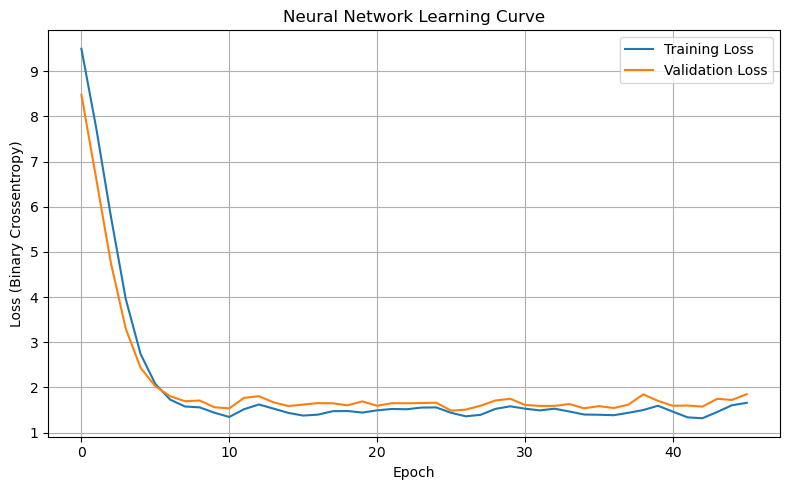

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Learning Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [23]:
y_pred = model.predict(X_val).flatten()
y_pred = (model.predict(X_val) >= 0.5).astype(int)
print(classification_report(y_val, y_pred))

3/3 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.74      0.76      0.75        49
           1       0.65      0.63      0.64        35

    accuracy                           0.70        84
   macro avg       0.69      0.69      0.69        84
weighted avg       0.70      0.70      0.70        84



3/3 [==============================] - 0s 2ms/step


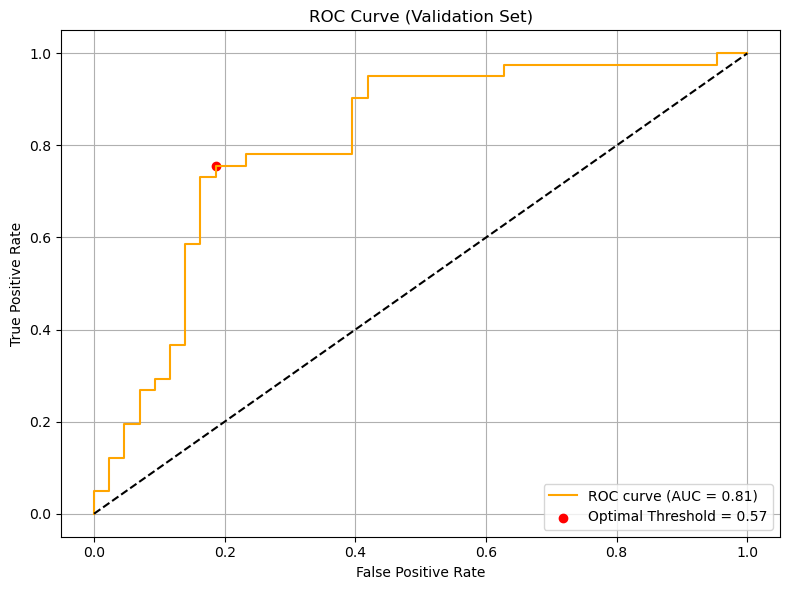

(0.57261634, 0.807146908678389)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

y_val_pred_prob = model.predict(X_val).flatten()

fpr, tpr, thresholds = roc_curve(y_val, y_val_pred_prob)
roc_auc = roc_auc_score(y_val, y_val_pred_prob)

j_scores = tpr - fpr
optimal_idx = np.argmax(j_scores)
optimal_threshold = thresholds[optimal_idx]

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label=f"Optimal Threshold = {optimal_threshold:.2f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Validation Set)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

optimal_threshold, roc_auc

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

val_accuracy, val_precision, val_recall, val_f1, val_roc_auc = [], [], [], [], []
train_accuracy, train_precision, train_recall, train_f1, train_roc_auc = [], [], [], [], []

regularization = 0.015
learning_rate = 0.01
activation_function = 'relu'

for i in range(1):
    model = Sequential([
        Dense(256, activation=activation_function, kernel_regularizer=l2(regularization), input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation=activation_function, kernel_regularizer=l2(regularization)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation=activation_function, kernel_regularizer=l2(regularization)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(32, activation=activation_function, kernel_regularizer=l2(regularization)),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(patience=20, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=32,
        verbose=0,
        callbacks=[early_stop]
    )

    y_train_pred_prob = model.predict(X_train).flatten()
    y_val_pred_prob = model.predict(X_val).flatten()
    y_train_pred = (y_train_pred_prob > 0.5).astype(int)
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)

    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    train_precision.append(precision_score(y_train, y_train_pred, zero_division=0))
    train_recall.append(recall_score(y_train, y_train_pred, zero_division=0))
    train_f1.append(f1_score(y_train, y_train_pred, zero_division=0))
    train_roc_auc.append(roc_auc_score(y_train, y_train_pred_prob))

    val_accuracy.append(accuracy_score(y_val, y_val_pred))
    val_precision.append(precision_score(y_val, y_val_pred, zero_division=0))
    val_recall.append(recall_score(y_val, y_val_pred, zero_division=0))
    val_f1.append(f1_score(y_val, y_val_pred, zero_division=0))
    val_roc_auc.append(roc_auc_score(y_val, y_val_pred_prob))

print(np.mean(val_accuracy))
print(np.mean(train_accuracy))

ValueError: in user code:

    File "/opt/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1852, in test_function  *
        return step_function(self, iterator)
    File "/opt/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1836, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1824, in run_step  **
        outputs = model.test_step(data)
    File "/opt/anaconda3/lib/python3.11/site-packages/keras/engine/training.py", line 1788, in test_step
        y_pred = self(x, training=False)
    File "/opt/anaconda3/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/anaconda3/lib/python3.11/site-packages/keras/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_335' (type Sequential).
    
    Input 0 of layer "dense_1695" is incompatible with the layer: expected axis -1 of input shape to have value 41, but received input with shape (None, 1)
    
    Call arguments received by layer 'sequential_335' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 1), dtype=float32)
      • training=False
      • mask=None


In [ ]:
print(f"Training Accuracy: {np.mean(train_accuracy):.2f} ± {np.std(train_accuracy):.2f}")
print(f"Training Precision: {np.mean(train_precision):.2f} ± {np.std(train_precision):.2f}")
print(f"Training Recall: {np.mean(train_recall):.2f} ± {np.std(train_recall):.2f}")
print(f"Training F1 Score: {np.mean(train_f1):.2f} ± {np.std(train_f1):.2f}")
print(f"Training ROC AUC: {np.mean(train_roc_auc):.2f} ± {np.std(train_roc_auc):.2f}")

print(f"Validation Accuracy: {np.mean(val_accuracy):.2f} ± {np.std(val_accuracy):.2f}")
print(f"Validation Precision: {np.mean(val_precision):.2f} ± {np.std(val_precision):.2f}")
print(f"Validation Recall: {np.mean(val_recall):.2f} ± {np.std(val_recall):.2f}")
print(f"Validation F1 Score: {np.mean(val_f1):.2f} ± {np.std(val_f1):.2f}")
print(f"Validation ROC AUC: {np.mean(val_roc_auc):.2f} ± {np.std(val_roc_auc):.2f}")

Training Accuracy: 0.83 ± 0.03
Training Precision: 0.82 ± 0.07
Training Recall: 0.81 ± 0.13
Training F1 Score: 0.81 ± 0.06
Training ROC AUC: 0.92 ± 0.01
Validation Accuracy: 0.74 ± 0.04
Validation Precision: 0.71 ± 0.06
Validation Recall: 0.73 ± 0.17
Validation F1 Score: 0.70 ± 0.10
Validation ROC AUC: 0.83 ± 0.03


In [ ]:
val_accuracy, val_precision, val_recall, val_f1, val_roc_auc = [], [], [], [], []
train_accuracy, train_precision, train_recall, train_f1, train_roc_auc = [], [], [], [], []

regularization = 0.008
learning_rate = 0.01
activation_function = 'gelu'

for i in range(5):
    model = Sequential([
        Dense(256, activation=activation_function, kernel_regularizer=l2(regularization), input_shape=(X_train.shape[1],)),
        BatchNormalization(),
        Dropout(0.4),
        Dense(128, activation=activation_function, kernel_regularizer=l2(regularization)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation=activation_function, kernel_regularizer=l2(regularization)),
        BatchNormalization(),
        Dropout(0.2),
        Dense(32, activation=activation_function, kernel_regularizer=l2(regularization)),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(patience=20, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=300,
        batch_size=32,
        verbose=0,
        callbacks=[early_stop]
    )

    y_train_pred_prob = model.predict(X_train).flatten()
    y_val_pred_prob = model.predict(X_val).flatten()
    y_train_pred = (y_train_pred_prob > 0.5).astype(int)
    y_val_pred = (y_val_pred_prob > 0.5).astype(int)

    train_accuracy.append(accuracy_score(y_train, y_train_pred))
    train_precision.append(precision_score(y_train, y_train_pred, zero_division=0))
    train_recall.append(recall_score(y_train, y_train_pred, zero_division=0))
    train_f1.append(f1_score(y_train, y_train_pred, zero_division=0))
    train_roc_auc.append(roc_auc_score(y_train, y_train_pred_prob))

    val_accuracy.append(accuracy_score(y_val, y_val_pred))
    val_precision.append(precision_score(y_val, y_val_pred, zero_division=0))
    val_recall.append(recall_score(y_val, y_val_pred, zero_division=0))
    val_f1.append(f1_score(y_val, y_val_pred, zero_division=0))
    val_roc_auc.append(roc_auc_score(y_val, y_val_pred_prob))

print(np.mean(val_accuracy))
print(np.mean(train_accuracy))

3/3 [==============================] - 0s 1ms/step


3/3 [==============================] - 0s 2ms/step


3/3 [==============================] - 0s 812us/step


3/3 [==============================] - 0s 735us/step


3/3 [==============================] - 0s 1ms/step
0.7190476190476189
0.7537848605577689


In [ ]:
print(f"Training Accuracy: {np.mean(train_accuracy):.2f} ± {np.std(train_accuracy):.2f}")
print(f"Training Precision: {np.mean(train_precision):.2f} ± {np.std(train_precision):.2f}")
print(f"Training Recall: {np.mean(train_recall):.2f} ± {np.std(train_recall):.2f}")
print(f"Training F1 Score: {np.mean(train_f1):.2f} ± {np.std(train_f1):.2f}")
print(f"Training ROC AUC: {np.mean(train_roc_auc):.2f} ± {np.std(train_roc_auc):.2f}")
print(f"Validation Accuracy: {np.mean(val_accuracy):.2f} ± {np.std(val_accuracy):.2f}")
print(f"Validation Precision: {np.mean(val_precision):.2f} ± {np.std(val_precision):.2f}")
print(f"Validation Recall: {np.mean(val_recall):.2f} ± {np.std(val_recall):.2f}")
print(f"Validation F1 Score: {np.mean(val_f1):.2f} ± {np.std(val_f1):.2f}")
print(f"Validation ROC AUC: {np.mean(val_roc_auc):.2f} ± {np.std(val_roc_auc):.2f}")

Training Accuracy: 0.75 ± 0.04
Training Precision: 0.68 ± 0.05
Training Recall: 0.92 ± 0.04
Training F1 Score: 0.78 ± 0.02
Training ROC AUC: 0.87 ± 0.03
Validation Accuracy: 0.72 ± 0.04
Validation Precision: 0.63 ± 0.04
Validation Recall: 0.92 ± 0.02
Validation F1 Score: 0.74 ± 0.02
Validation ROC AUC: 0.81 ± 0.03


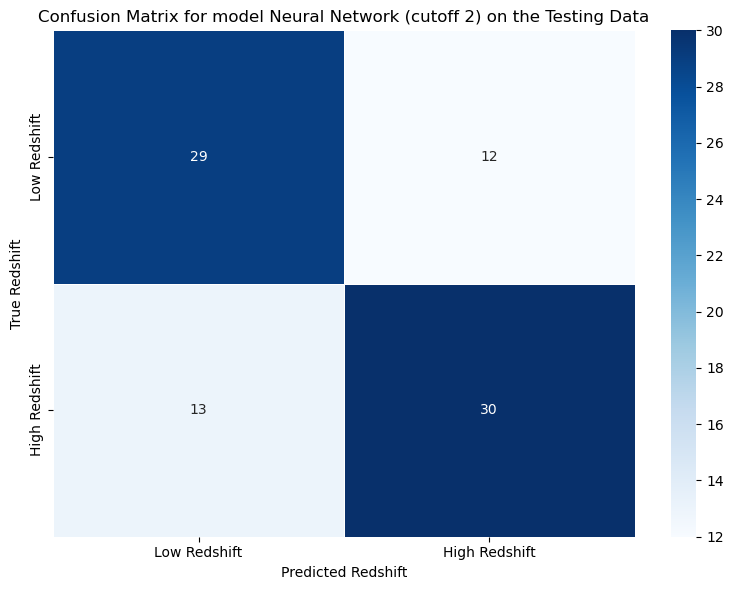

Classification Metrics for Single Run on the Testing Data
Metric       Value
---------  -------
Accuracy      0.7
Precision     0.71
Recall        0.7
F1 Score      0.71


In [534]:
plot_confusion_matrix_and_stats(y_test, y_test_pred, 'Neural Network', 2, 'Testing Data')

In [387]:
#here we implement a little bit of hyperparameter tuning on the gaussian naive bayes model
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6]} #after playing with this parameter, it just seems to prefer a paramter value of 0
#i.e., if i keep lowering the parameter it will keep selecting the lowest value.
model = GaussianNB()
grid = GridSearchCV(model, param_grid, cv=kfold, scoring='accuracy')
grid.fit(X_scaled, y)
var_smoothing = grid.best_params_['var_smoothing']
print("Best parameters for Gaussian Naive Bayes:", var_smoothing)
print("Best cross-validation score for Gaussian Naive Bayes (accurracy):", grid.best_score_) 

Best parameters for Gaussian Naive Bayes: 1e-09
Best cross-validation score for Gaussian Naive Bayes (accurracy): 0.6858208955223879


In [ ]:
final_nb_model = GaussianNB(var_smoothing=var_smoothing)
final_nb_model.fit(X_scaled, y)
y_test_pred = final_nb_model.predict(X_test_scaled)
y_test_pred_proba = final_nb_model.predict_proba(X_test_scaled)[:, 1]
print("Gaussian Naive Bayes Test Performance:")
print(f"Accuracy : {accuracy_score(y_test, y_test_pred):.3f}")
print(f"Precision: {precision_score(y_test, y_test_pred, zero_division=0):.3f}")
print(f"Recall   : {recall_score(y_test, y_test_pred, zero_division=0):.3f}")
print(f"F1 Score : {f1_score(y_test, y_test_pred, zero_division=0):.3f}")
print(f"ROC AUC  : {roc_auc_score(y_test, y_test_pred_proba):.3f}")

Gaussian Naive Bayes Test Performance:
Accuracy : 0.667
Precision: 0.571
Recall   : 0.889
F1 Score : 0.696
ROC AUC  : 0.776


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
log_model = LogisticRegression(C=1.1, penalty='l2', solver='lbfgs', max_iter=1000)
log_model.fit(X_scaled, y)
y_test_log_proba = log_model.predict_proba(X_test_scaled)[:, 1]
y_test_log_pred = (y_test_log_proba > 0.5).astype(int)
print("Final Test Set Evaluation (Logistic Regression):")
print("Accuracy :", round(accuracy_score(y_test, y_test_log_pred), 3))
print("Precision:", round(precision_score(y_test, y_test_log_pred, zero_division=0), 3))
print("ROC AUC  :", round(roc_auc_score(y_test, y_test_log_proba), 3))

Final Test Set Evaluation (Logistic Regression):
Accuracy : 0.726
Precision: 0.638
ROC AUC  : 0.713


In [ ]:
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
gb_model = GradientBoostingClassifier(
    learning_rate=0.003,
    max_depth=2,
    min_samples_leaf=20,
    min_samples_split=20,
    n_estimators=500,
    subsample=0.55,
    max_features='log2'
)
gb_model.fit(X_scaled, y)
y_test_gb_proba = gb_model.predict_proba(X_test_scaled)[:, 1]
y_test_gb_pred = (y_test_gb_proba > 0.5).astype(int)
print("Final Test Set Evaluation (Gradient Boosting):")
print("Accuracy :", round(accuracy_score(y_test, y_test_gb_pred), 3))
print("Precision:", round(precision_score(y_test, y_test_gb_pred, zero_division=0), 3))
print("ROC AUC  :", round(roc_auc_score(y_test, y_test_gb_proba), 3))


Final Test Set Evaluation (Gradient Boosting):
Accuracy : 0.69
Precision: 0.6
ROC AUC  : 0.788


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score

X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
rf_model = RandomForestClassifier(
    criterion='entropy',
    max_depth=2,
    min_samples_leaf=25,
    min_samples_split=25,
    n_estimators=100,
)
rf_model.fit(X_scaled, y)
y_test_rf_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
y_test_rf_pred = (y_test_rf_proba > 0.5).astype(int)
print("Final Test Set Evaluation (Random Forest):")
print("Accuracy :", round(accuracy_score(y_test, y_test_rf_pred), 3))
print("Precision:", round(precision_score(y_test, y_test_rf_pred, zero_division=0), 3))
print("ROC AUC  :", round(roc_auc_score(y_test, y_test_rf_proba), 3))


Final Test Set Evaluation (Random Forest):
Accuracy : 0.679
Precision: 0.585
ROC AUC  : 0.786


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
dt_model = DecisionTreeClassifier(
    criterion='gini',
    max_depth=4,
    min_samples_split=8,
    min_samples_leaf=20,
    max_features='sqrt',
)
dt_model.fit(X_scaled, y)
y_test_dt_proba = dt_model.predict_proba(X_test_scaled)[:, 1]
y_test_dt_pred = (y_test_dt_proba > 0.5).astype(int)
print("Final Test Set Evaluation (Decision Tree):")
print("Accuracy :", round(accuracy_score(y_test, y_test_dt_pred), 3))
print("Precision:", round(precision_score(y_test, y_test_dt_pred, zero_division=0), 3))
print("ROC AUC  :", round(roc_auc_score(y_test, y_test_dt_proba), 3))


Final Test Set Evaluation (Decision Tree):
Accuracy : 0.667
Precision: 0.58
ROC AUC  : 0.709


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score

X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
xgb_model = XGBClassifier(
    learning_rate=0.01,
    max_depth=3,
    min_child_weight=5,
    n_estimators=300,
    subsample=0.5,
    colsample_bytree=0.5,
    gamma=4,
    reg_alpha=3,
    reg_lambda=5,
    use_label_encoder=False,
    eval_metric='logloss',
)
xgb_model.fit(X_scaled.values, y)

y_test_xgb_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
y_test_xgb_pred = (y_test_xgb_proba > 0.5).astype(int)
print("Final Test Set Evaluation (XGBoost):")
print("Accuracy :", round(accuracy_score(y_test, y_test_xgb_pred), 3))
print("Precision:", round(precision_score(y_test, y_test_xgb_pred, zero_division=0), 3))
print("ROC AUC  :", round(roc_auc_score(y_test, y_test_xgb_proba), 3))


Final Test Set Evaluation (XGBoost):
Accuracy : 0.679
Precision: 0.592
ROC AUC  : 0.762


/opt/anaconda3/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [00:21:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
